In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import os
import dotenv

This step improts the FIPS data and subsets it to the group of desired states in our anlaysis. 

In [ ]:
# Importing FIPS
url = "https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county"


response = requests.get(url)
html_content = response.content


soup = BeautifulSoup(html_content, "html.parser")


table = soup.find("table", {"class": "wikitable"})


rows = table.find_all("tr")


data = []


for row in rows[1:]:  # Skip the header row
    cols = row.find_all("td")

    if len(cols) >= 2:  # Ensure the row has at least two columns

        fips_code = cols[0].text.strip()

        county_name = cols[1].text.strip()

        data.append({"FIPS Code": fips_code, "County Name": county_name})


county_fips_df = pd.DataFrame(data)


county_fips_df.to_csv("county_fips.csv", index=False)


print(county_fips_df.head(10))

Below we add a mapping for:
- Each State FIPS (first 2 digits of a FIPS code)
- The corresponsing 2 letter abbreviation for these states

In [ ]:
# Adjusting FIPS
first_2 = ["53", "01", "13", "23", "08", "12", "40", "41"]


mapping = {
    "53": "WA",
    "01": "AL",
    "13": "GA",
    "23": "ME",
    "08": "CO",
    "12": "FL",
    "40": "OK",
    "41": "OR",
}


county_fips_df["state_FIPS"] = county_fips_df["FIPS Code"].str[:2]


fips_df = county_fips_df[county_fips_df["state_FIPS"].isin(first_2)].copy()


fips_df["State"] = fips_df["state_FIPS"].map(mapping)


fips_df = fips_df.rename(columns={"FIPS Code": "County_FIPS", "County Name": "County"})


print(len(fips_df))

525


In [ ]:
# IMporting Educaiton, Poverty, Unemployment
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
url = "https://raw.githubusercontent.com/MIDS-at-Duke/opioids-2024-data-queens-king/main/data/USDA_education_poverty_unemployment_income.parquet"
headers = {"Authorization": f"Bearer {GITHUB_TOKEN}"}
response = requests.get(url, headers=headers)
epu_df = pd.read_parquet("USDA_education_poverty_unemployment_income.parquet")
epu_df["FIPS"] = epu_df["FIPS"].apply(lambda x: str(x).zfill(5))
epu_df["YR"].value_counts()
desired_years = ["2008-2012", "2015", "2014", "2017", "2016", "2021"]
epu_df1 = epu_df[epu_df["YR"].isin(desired_years)]
epu_df1.sample(5)

,FIPS,Name,RUC Code,YR,Completing College,Completing High School Only,Not Completing High School,All people in poverty (2021) Percent,Children ages 0-17 in poverty (2021) Percent,Median Household Income (2021),Unemployment Rate (%)
1476,08057,None,NaN,2015,None,None,None,NaN,NaN,None,3.6
245,01031,None,NaN,2014,None,None,None,NaN,NaN,None,6.6
263,01033,None,NaN,2017,None,None,None,NaN,NaN,None,5.3
862,01113,None,NaN,2016,None,None,None,NaN,NaN,None,5.6
6510,40111,None,NaN,2017,None,None,None,NaN,NaN,None,6.0


In [ ]:
# This code expands the '2008-2012' lines into individual lines for 2008, 2009, 2010, 2011. 2012
expanded_rows = []
for index, row in epu_df1.iterrows():
    if "-" in row["YR"]:
        start, end = map(int, row["YR"].split("-"))
        for year in range(start, end + 1):
            new_row = row.copy()
            new_row["YR"] = year
            expanded_rows.append(new_row)
    else:
        expanded_rows.append(row)
epu_df2 = pd.DataFrame(expanded_rows)
epu_df2.reset_index(drop=True, inplace=True)
print(epu_df2.head(30))

     FIPS                 Name  RUC Code    YR Completing College  \
0   01000              Alabama       NaN  2008              22.3%   
1   01000              Alabama       NaN  2009              22.3%   
2   01000              Alabama       NaN  2010              22.3%   
3   01000              Alabama       NaN  2011              22.3%   
4   01000              Alabama       NaN  2012              22.3%   
5   01000                 None       NaN  2014               None   
6   01000                 None       NaN  2015               None   
7   01000                 None       NaN  2016               None   
8   01000                 None       NaN  2017               None   
9   01000                 None       NaN  2021               None   
10  01001  Autauga, AL               2.0  2008              21.7%   
11  01001  Autauga, AL               2.0  2009              21.7%   
12  01001  Autauga, AL               2.0  2010              21.7%   
13  01001  Autauga, AL            

In [ ]:
import pandas as pd
import os

# Define the path to the Parquet file in the data folder
file_path = os.path.join("data", "USDA_population2021.parquet")

# Attempt to load the Parquet file from the data folder
try:
    pop = pd.read_parquet(file_path)

    # Process the DataFrame
    # Ensure FIPS codes have leading zeros
    pop["FIPS"] = pop["FIPS"].apply(lambda x: str(x).zfill(5))
    # Rename the FIPS column
    pop = pop.rename(columns={"FIPS": "County_FIPS"})

    # Print the first 5 rows
    print(pop.head(5))
except Exception as e:
    print("Error reading Parquet file:", e)

  County_FIPS State            Name    YR Estimated Population
0       01000    AL         Alabama  2021            5,050,380
1       01001    AL  Autauga County  2021               59,203
2       01003    AL  Baldwin County  2021              239,439
3       01005    AL  Barbour County  2021               24,533
4       01007    AL     Bibb County  2021               22,359


In [ ]:
# Merging FIPS on pop

fips_pop = pd.merge(
    fips_df, pop, how="left", on=["County_FIPS"], indicator=True, validate="1:1"
)

missing_values = fips_pop.isna().sum()

# print(f"By computing the total missing values in fips_pop after the merge the following is obtained:{missing_values}")


fips_pop.head(5)
fips_pop = fips_pop[
    [
        "County_FIPS",
        "County",
        "state_FIPS",
        "State_x",
        "YR",
        "Estimated Population",
        "_merge",
    ]
]
fips_pop = fips_pop.rename(
    columns={
        "State_x": "State",
        "YR": "pop_Year",
        "Estimated Population": "pop_Population",
        "_merge": "pop_merge_indicator",
    }
)

fips_pop["pop_merge_indicator"].value_counts()
# print(f"By computing the total missing values in fips_pop after the merge the following is obtained:{missing_values}")

pop_merge_indicator
both          525
left_only       0
right_only      0
Name: count, dtype: int64

In [ ]:
import pandas as pd
import os

# Define the path to the Parquet file in the data folder
file_path = os.path.join("data", "USDA_poverty2021.parquet")

# Attempt to load the Parquet file from the data folder
try:
    pov = pd.read_parquet(file_path)

    # Process the DataFrame
    # Ensure FIPS codes have leading zeros
    pov["FIPS"] = pov["FIPS"].apply(lambda x: str(x).zfill(5))
    # Rename the FIPS column
    pov = pov.rename(columns={"FIPS": "County_FIPS"})
    # Select and rename specific columns
    pov = pov[["County_FIPS", "All people in poverty (2021) Percent"]]
    pov = pov.rename(
        columns={"All people in poverty (2021) Percent": "pov_poverty_rate_percent"}
    )

    # Print the first 5 rows
    print(pov.head(5))
except Exception as e:
    print("Error reading Parquet file:", e)

  County_FIPS  pov_poverty_rate_percent
0       23000                      11.2
1       23001                      14.0
2       23003                      14.9
3       23005                       7.7
4       23007                      11.7


In [ ]:
# Merging FIPS_POP on POV
fpp = pd.merge(
    fips_pop, pov, how="left", on=["County_FIPS"], indicator=True, validate="1:1"
)
fpp = fpp.rename(columns={"_merge": "pov_merge_indicator"})

fpp["pov_merge_indicator"].value_counts()

pov_merge_indicator
both          525
left_only       0
right_only      0
Name: count, dtype: int64

In [ ]:
fpp["County"] = fpp["County"].str.upper().str.replace(" COUNTY", "", regex=False)
fpp.head(20)

,County_FIPS,County,state_FIPS,State,pop_Year,pop_Population,pop_merge_indicator,pov_poverty_rate_percent,pov_merge_indicator
0,01001,AUTAUGA,01,AL,2021,"59,203",both,10.7,both
1,01003,BALDWIN,01,AL,2021,"239,439",both,10.8,both
2,01005,BARBOUR,01,AL,2021,"24,533",both,23.0,both
3,01007,BIBB,01,AL,2021,"22,359",both,20.6,both
4,01009,BLOUNT,01,AL,2021,"59,079",both,12.0,both
5,01011,BULLOCK,01,AL,2021,"10,143",both,32.1,both
6,01013,BUTLER,01,AL,2021,"18,890",both,22.7,both
7,01015,CALHOUN,01,AL,2021,"115,678",both,19.2,both
8,01017,CHAMBERS,01,AL,2021,"34,488",both,19.7,both
9,01019,CHEROKEE,01,AL,2021,"25,074",both,18.2,both


In [ ]:
# Importing Median Income Data
# Importing Poverty Data
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
url_4 = "https://raw.githubusercontent.com/MIDS-at-Duke/opioids-2024-data-queens-king/main/data/USDA_medIncome2021.parquet"
headers = {"Authorization": f"Bearer {GITHUB_TOKEN}"}
response = requests.get(url_4, headers=headers)
with open("USDA_medIncome2021.parquet", "wb") as file:
    file.write(response.content)
minc = pd.read_parquet("USDA_medIncome2021.parquet")


minc["FIPS_Code"] = minc["FIPS_Code"].apply(lambda x: str(x).zfill(5))
minc = minc[["FIPS_Code", "Median_Household_Income_2021"]]
minc = minc.rename(
    columns={
        "FIPS_Code": "County_FIPS",
        "Median_Household_Income_2021": "minc_median_income_USD_2021",
    }
)

# pov["FIPS"] = pov["FIPS"].apply(lambda x: str(x).zfill(5))
# pov = pov.rename(columns={"FIPS": "County_FIPS"})
# pov = pov[["County_FIPS", "All people in poverty (2021) Percent"]]
# pov = pov.rename(
#     columns={"All people in poverty (2021) Percent": "pov_poverty_rate_percent"}
# )
minc.head(5)

,County_FIPS,minc_median_income_USD_2021
0,01000,"53,990"
1,01001,"66,444"
2,01003,"65,658"
3,01005,"38,649"
4,01007,"48,454"


In [ ]:
fppi = pd.merge(
    fpp, minc, how="left", on=["County_FIPS"], indicator=True, validate="1:1"
)

fppi = fppi.rename(columns={"_merge": "minc_merge_indicator"})


fppi["pop_merge_indicator"].value_counts()

pop_merge_indicator
both          525
left_only       0
right_only      0
Name: count, dtype: int64

In [ ]:
# Importing Opioid Shipment Data
file_path = "data/opioid_shipment_WA_FL_andconstants.parquet"


opioid = pd.read_parquet(file_path)

county_adj_dict_op = {"DE KALB": "DEKALB"}


opioid["BUYER_COUNTY"].replace(county_adj_dict_op)

opioid.loc[
    (opioid["BUYER_COUNTY"].str.startswith("DE", na=False))
    & (opioid["BUYER_STATE"] == "AL"),
    "BUYER_COUNTY",
] = opioid["BUYER_COUNTY"].str.replace(" ", "", regex=False)


opioid["state-county"] = opioid["BUYER_STATE"] + "|" + opioid["BUYER_COUNTY"]


opioid.head(2)


opioid["state-county-yr"] = opioid["state-county"] + "|" + opioid["year"].astype("str")


unique_id_of_op = opioid["state-county-yr"].nunique()


length_op = len(opioid)


print(
    f"the length of the opioid dataset is {unique_id_of_op} while the distinctcount of the unique id state-county-yr is {length_op}"
)

opioid["year"].value_counts()

the length of the opioid dataset is 7128 while the distinctcount of the unique id state-county-yr is 7128


year
2006    513
2011    511
2010    511
2014    511
2009    510
2007    510
2013    510
2012    510
2008    509
2016    508
2019    507
2018    507
2015    506
2017    505
Name: count, dtype: int64

In [ ]:
opioid = opioid.rename(
    columns={
        "year": "opioid_YEAR",
        "BUYER_STATE": "opioid_State",
        "BUYER_COUNTY": "opioid_County",
        "morphine_equivalent_g": "opioid_morphine_equivalent_g",
        "state-county": "state_county",
        "state-county-yr": "opioid_state_county_yr",
    }
)

opioid_unique_counties = opioid[
    ["state_county", "opioid_State", "opioid_County"]
].drop_duplicates()

In [ ]:
county_adj_dict = {
    "DE KALB": "DEKALB",
    "ST. CLAIR": "SAINT CLAIR",
    "BROOMFIELD, CITY AND OF[I]": "BROOMFIELD",
    "DENVER, CITY AND OF[J]": "DENVER",
    "DESOTO": "DE SOTO",
    "ST. JOHNS": "SAINT JOHNS",
    "ST. LUCIE": "SAINT LUCIE",
}
fppi["County"] = fppi["County"].replace(county_adj_dict)


fppi["state_county"] = fppi["State"] + "|" + fppi["County"]
fpp_opioid = pd.merge(
    fppi, opioid, how="left", on=["state_county"], indicator=True, validate="1:m"
)

fpp_opioid = fpp_opioid.rename(columns={"_merge": "opioid_merge_indicator"})

fpp_opioid["opioid_merge_indicator"].value_counts()

left_only = fpp_opioid[fpp_opioid["opioid_merge_indicator"] == "left_only"]

print(len(fpp_opioid))

7136


In [ ]:
# Dropping Counties that did not record opioid shipments
des_yr = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

fpp_opioid = fpp_opioid[fpp_opioid["opioid_merge_indicator"] == "both"]
fpp_opioid["opioid_YEAR"] = fpp_opioid["opioid_YEAR"].astype("int")
fpp_opioid["FIPS|YEAR"] = (
    fpp_opioid["County_FIPS"] + "|" + fpp_opioid["opioid_YEAR"].astype("str")
)
fpp_opioid = fpp_opioid[fpp_opioid["opioid_YEAR"].isin(des_yr)]

In [ ]:
import pandas as pd
import os

# Define the path to the Parquet file in the data folder
file_path = os.path.join("data", "mortality_data.parquet")

# Define the desired years
des_yr = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

# Attempt to load the Parquet file from the data folder
try:
    mort = pd.read_parquet(file_path)

    # Process the DataFrame
    # Select and rename columns
    mort = mort[["county_code", "year", "deaths"]]
    mort = mort.rename(
        columns={
            "deaths": "mort_overdose_deaths",
            "county_code": "County_FIPS",
            "year": "mort_year",
        }
    )

    # Create the 'FIPS|YEAR' column
    mort["FIPS|YEAR"] = (
        mort["County_FIPS"].astype("str") + "|" + mort["mort_year"].astype("str")
    )

    # Filter rows for the desired years
    mort = mort[mort["mort_year"].isin(des_yr)]

    # Print the first 5 rows
    print(mort.head(5))
except Exception as e:
    print("Error reading Parquet file:", e)

  County_FIPS  mort_year  mort_overdose_deaths   FIPS|YEAR
3       01003       2006                    11  01003|2006
4       01003       2007                    24  01003|2007
5       01003       2008                    19  01003|2008
6       01003       2009                    29  01003|2009
7       01003       2010                    24  01003|2010


In [ ]:
merged_dataset = pd.merge(
    fpp_opioid, mort, how="left", on=["FIPS|YEAR"], indicator=True, validate="1:1"
)


merged_dataset = merged_dataset.rename(columns={"_merge": "mort_merge_indicator"})

merged_dataset["mort_merge_indicator"].value_counts()


output_path = os.path.join("data", "merged_dataset.csv")


merged_dataset.to_csv(output_path, index=False)


merged_dataset["mort_merge_indicator"].value_counts()

mort_merge_indicator
left_only     3812
both          1289
right_only       0
Name: count, dtype: int64

In [ ]:
no_mort_match = merged_dataset[merged_dataset["mort_merge_indicator"] == "left_only"]

df0 = pd.DataFrame(no_mort_match["State"].value_counts())

print(df0)

print(len(no_mort_match))

       count
State       
GA      1256
OK       643
AL       520
CO       473
FL       310
OR       264
WA       233
ME       113
3812


In [ ]:
df1 = pd.DataFrame(merged_dataset["State"].value_counts())

summary_tb = pd.merge(df1, df0, how="left", on=["State"])

summary_tb = summary_tb.rename(
    columns={
        "count_x": "Count of Counties",
        "count_y": "Count of Counties with no Mortality Data",
    }
)

summary_tb["%_missing_mortality"] = (
    100
    * round(
        summary_tb["Count of Counties with no Mortality Data"]
        / summary_tb["Count of Counties"],
        2,
    )
).astype("int").astype("str") + "%"

print(summary_tb)

       Count of Counties  Count of Counties with no Mortality Data  \
State                                                                
GA                  1518                                      1256   
OK                   770                                       643   
AL                   670                                       520   
FL                   667                                       310   
CO                   580                                       473   
WA                   390                                       233   
OR                   346                                       264   
ME                   160                                       113   

      %_missing_mortality  
State                      
GA                    83%  
OK                    84%  
AL                    78%  
FL                    46%  
CO                    82%  
WA                    60%  
OR                    76%  
ME                    71%  


Filtered data shape: (193, 23)
Sample of filtered data:
    County_FIPS_x  pop_Population  mort_overdose_deaths
10          01003          239439                  11.0
42          01009           59079                  15.0
71          01015          115678                  11.0
100         01021           45259                  13.0
212         01043           89639                  10.0


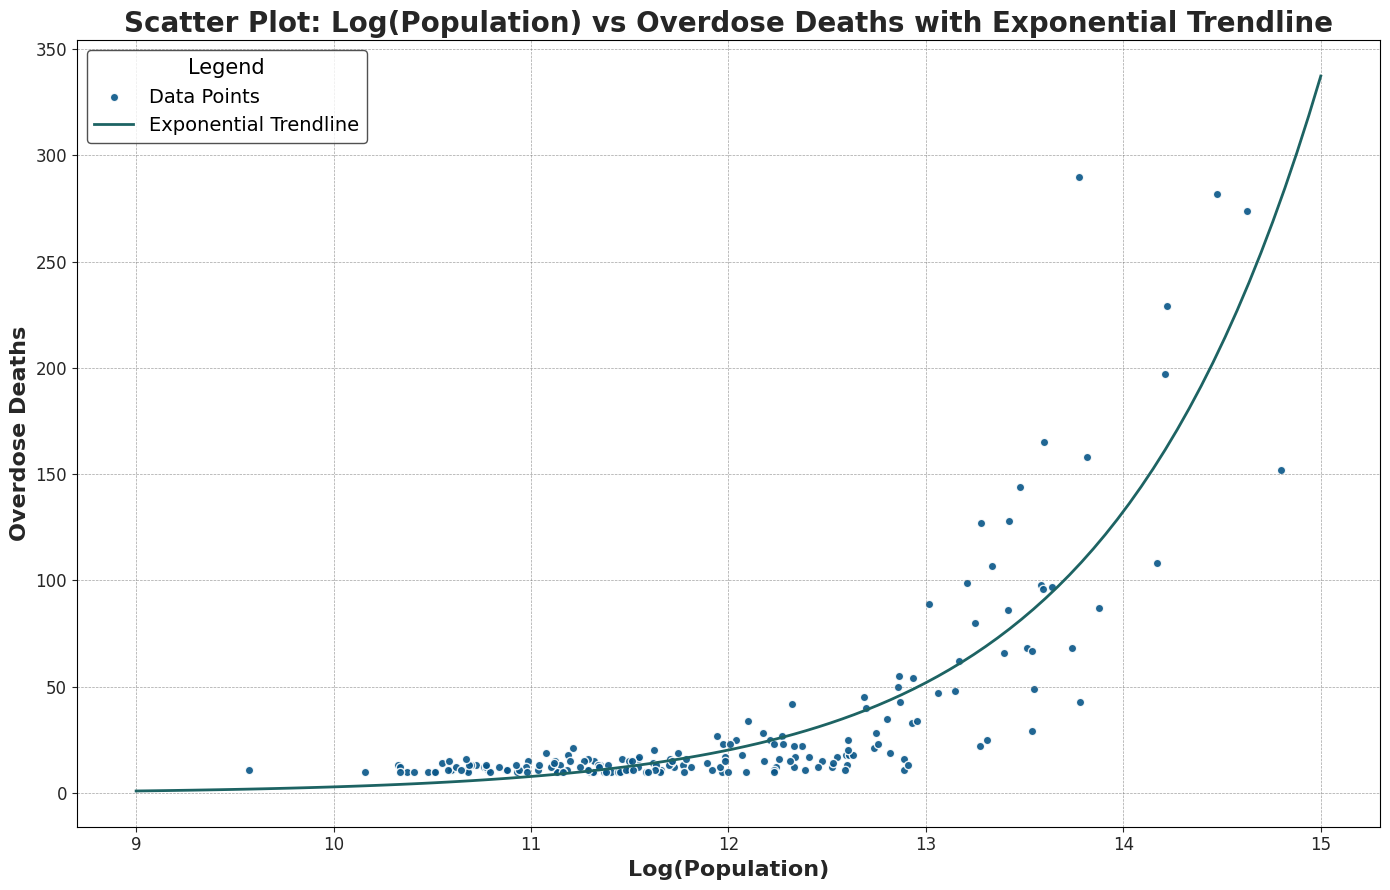

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Step 1: Clean population data and ensure numeric
if "pop_Population" in merged_dataset.columns:
    merged_dataset["pop_Population"] = (
        merged_dataset["pop_Population"].astype(str).str.replace(",", "")
    )
    merged_dataset["pop_Population"] = pd.to_numeric(
        merged_dataset["pop_Population"], errors="coerce"
    )

# Step 2: Filter data and ensure uniqueness
filtered_data = merged_dataset[
    (merged_dataset["mort_merge_indicator"] == "both")
    & (merged_dataset["pop_Population"].notna())
    & (merged_dataset["mort_overdose_deaths"].notna())
].drop_duplicates(subset=["County_FIPS_x"])
filtered_data = filtered_data[filtered_data["pop_Population"] > 0]

# Debugging Outputs
print(f"Filtered data shape: {filtered_data.shape}")
print("Sample of filtered data:")
print(filtered_data[["County_FIPS_x", "pop_Population", "mort_overdose_deaths"]].head())


# Step 3: Define exponential model
def exponential_model(x, a, b, c):
    return a * np.exp(b * x) + c


# Fit the model
log_population = np.log(filtered_data["pop_Population"])
overdose_deaths = filtered_data["mort_overdose_deaths"]

params, _ = curve_fit(
    exponential_model, log_population, overdose_deaths, p0=(1, 0.1, 1)
)

# Generate trendline points
x_vals = np.linspace(9, 15, 100)
y_vals = exponential_model(x_vals, *params)

# Step 4: Create scatter plot
plt.figure(figsize=(14, 9))

# Scatter plot
plt.scatter(
    log_population,
    overdose_deaths,
    color="#085587",  # Duke blue for data points
    edgecolors="white",
    alpha=0.9,
    label="Data Points",
)

# Trendline
plt.plot(
    x_vals,
    y_vals,
    color="#1D6363",  # Magnolia for trendline
    linewidth=2,
    label="Exponential Trendline",
)

# Plot styling
plt.gca().set_facecolor("#FFFFFF")  # White background
plt.title(
    "Scatter Plot: Log(Population) vs Overdose Deaths with Exponential Trendline",
    fontsize=20,
    color="#262626",
    weight="bold",
)
plt.xlabel("Log(Population)", fontsize=16, color="#262626", weight="bold")
plt.ylabel("Overdose Deaths", fontsize=16, color="#262626", weight="bold")
plt.legend(title="Legend", fontsize=14, title_fontsize=15, edgecolor="#262626")
plt.grid(color="#666666", linestyle="--", linewidth=0.5, alpha=0.6)
plt.tick_params(colors="#262626", labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Required imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Filter dataset for overdose counties and missing mortality match
overdose_counties = merged_dataset[
    merged_dataset["mort_merge_indicator"] == "both"
].copy()
no_mort_match = no_mort_match.copy()
print(len(no_mort_match))

# Drop rows with missing target or predictor values
overdose_counties = overdose_counties.dropna(
    subset=["pop_Population", "mort_overdose_deaths"]
)

# Remove commas and convert to integer
overdose_counties["pop_Population"] = (
    overdose_counties["pop_Population"].astype(str).str.replace(",", "").astype(int)
)
no_mort_match["pop_Population"] = (
    no_mort_match["pop_Population"].astype(str).str.replace(",", "").astype(int)
)

# Apply log transformation to population
overdose_counties["log_population"] = np.log(overdose_counties["pop_Population"])
no_mort_match["log_population"] = np.log(no_mort_match["pop_Population"])

# Ensure `log_population` is not NaN
no_mort_match = no_mort_match[no_mort_match["log_population"].notna()]

# Step 2: Define features and target for the model
X = overdose_counties[["log_population"]]
y = overdose_counties["mort_overdose_deaths"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.3f}")

# Predict overdose deaths for the `no_mort_match` dataset
no_mort_match["predicted_overdose_deaths"] = rf_model.predict(
    no_mort_match[["log_population"]]
)

# Add stochasticity to predictions
np.random.seed(42)
random_noise = np.random.normal(
    loc=0,
    scale=no_mort_match["predicted_overdose_deaths"] * 0.1,
    size=len(no_mort_match),
)
no_mort_match["predicted_overdose_deaths_stochastic"] = (
    no_mort_match["predicted_overdose_deaths"] + random_noise
).clip(lower=0)

no_mort_match.head(5)

3812
Mean Squared Error (MSE): 219.10
R² Score: 0.939


,County_FIPS_x,County,state_FIPS,State,pop_Year,pop_Population,pop_merge_indicator,pov_poverty_rate_percent,pov_merge_indicator,minc_median_income_USD_2021,...,opioid_state_county_yr,opioid_merge_indicator,FIPS|YEAR,County_FIPS_y,mort_year,mort_overdose_deaths,mort_merge_indicator,log_population,predicted_overdose_deaths,predicted_overdose_deaths_stochastic
0,01001,AUTAUGA,01,AL,2021,59203,both,10.7,both,"66,444",...,AL|AUTAUGA|2006,both,01001|2006,NaN,NaN,NaN,left_only,10.988727,11.607821,12.184398
1,01001,AUTAUGA,01,AL,2021,59203,both,10.7,both,"66,444",...,AL|AUTAUGA|2007,both,01001|2007,NaN,NaN,NaN,left_only,10.988727,11.607821,11.447327
2,01001,AUTAUGA,01,AL,2021,59203,both,10.7,both,"66,444",...,AL|AUTAUGA|2008,both,01001|2008,NaN,NaN,NaN,left_only,10.988727,11.607821,12.359647
3,01001,AUTAUGA,01,AL,2021,59203,both,10.7,both,"66,444",...,AL|AUTAUGA|2009,both,01001|2009,NaN,NaN,NaN,left_only,10.988727,11.607821,13.375727
4,01001,AUTAUGA,01,AL,2021,59203,both,10.7,both,"66,444",...,AL|AUTAUGA|2010,both,01001|2010,NaN,NaN,NaN,left_only,10.988727,11.607821,11.336020


In [ ]:
no_mort_match = no_mort_match[["FIPS|YEAR", "predicted_overdose_deaths_stochastic"]]

In [ ]:
final_dataset = pd.merge(
    merged_dataset,
    no_mort_match,
    how="left",
    on=["FIPS|YEAR"],
    indicator=True,
    validate="1:1",
)


final_dataset["_merge"].value_counts()

_merge
both          3812
left_only     1289
right_only       0
Name: count, dtype: int64

In [ ]:
final_dataset["mort_overdose_deaths"] = final_dataset["mort_overdose_deaths"].fillna(
    final_dataset["predicted_overdose_deaths_stochastic"]
)

final_dataset["pop_Population"] = (
    final_dataset["pop_Population"].astype(str).str.replace(",", "").astype(int)
)

final_dataset["mort_merge_indicator"] = final_dataset["mort_merge_indicator"].replace(
    {
        "left_only": "Random Forest Predicted Values",
        "both": "Actual Values(not missing)",
    }
)

final_dataset["pop_log_population"] = np.log(
    final_dataset["pop_Population"].astype("int")
)
final_dataset.head(5)

C:\Users\chris\AppData\Local\Temp\ipykernel_16992\2764750603.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  final_dataset["mort_merge_indicator"] = final_dataset["mort_merge_indicator"].replace(


,County_FIPS_x,County,state_FIPS,State,pop_Year,pop_Population,pop_merge_indicator,pov_poverty_rate_percent,pov_merge_indicator,minc_median_income_USD_2021,...,opioid_state_county_yr,opioid_merge_indicator,FIPS|YEAR,County_FIPS_y,mort_year,mort_overdose_deaths,mort_merge_indicator,predicted_overdose_deaths_stochastic,_merge,pop_log_population
0,01001,AUTAUGA,01,AL,2021,59203,both,10.7,both,"66,444",...,AL|AUTAUGA|2006,both,01001|2006,NaN,NaN,12.184398,Random Forest Predicted Values,12.184398,both,10.988727
1,01001,AUTAUGA,01,AL,2021,59203,both,10.7,both,"66,444",...,AL|AUTAUGA|2007,both,01001|2007,NaN,NaN,11.447327,Random Forest Predicted Values,11.447327,both,10.988727
2,01001,AUTAUGA,01,AL,2021,59203,both,10.7,both,"66,444",...,AL|AUTAUGA|2008,both,01001|2008,NaN,NaN,12.359647,Random Forest Predicted Values,12.359647,both,10.988727
3,01001,AUTAUGA,01,AL,2021,59203,both,10.7,both,"66,444",...,AL|AUTAUGA|2009,both,01001|2009,NaN,NaN,13.375727,Random Forest Predicted Values,13.375727,both,10.988727
4,01001,AUTAUGA,01,AL,2021,59203,both,10.7,both,"66,444",...,AL|AUTAUGA|2010,both,01001|2010,NaN,NaN,11.336020,Random Forest Predicted Values,11.336020,both,10.988727


C:\Users\chris\AppData\Local\Temp\ipykernel_16992\2382488554.py:25: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  final_dataset["mort_merge_indicator"] = final_dataset["mort_merge_indicator"].replace(


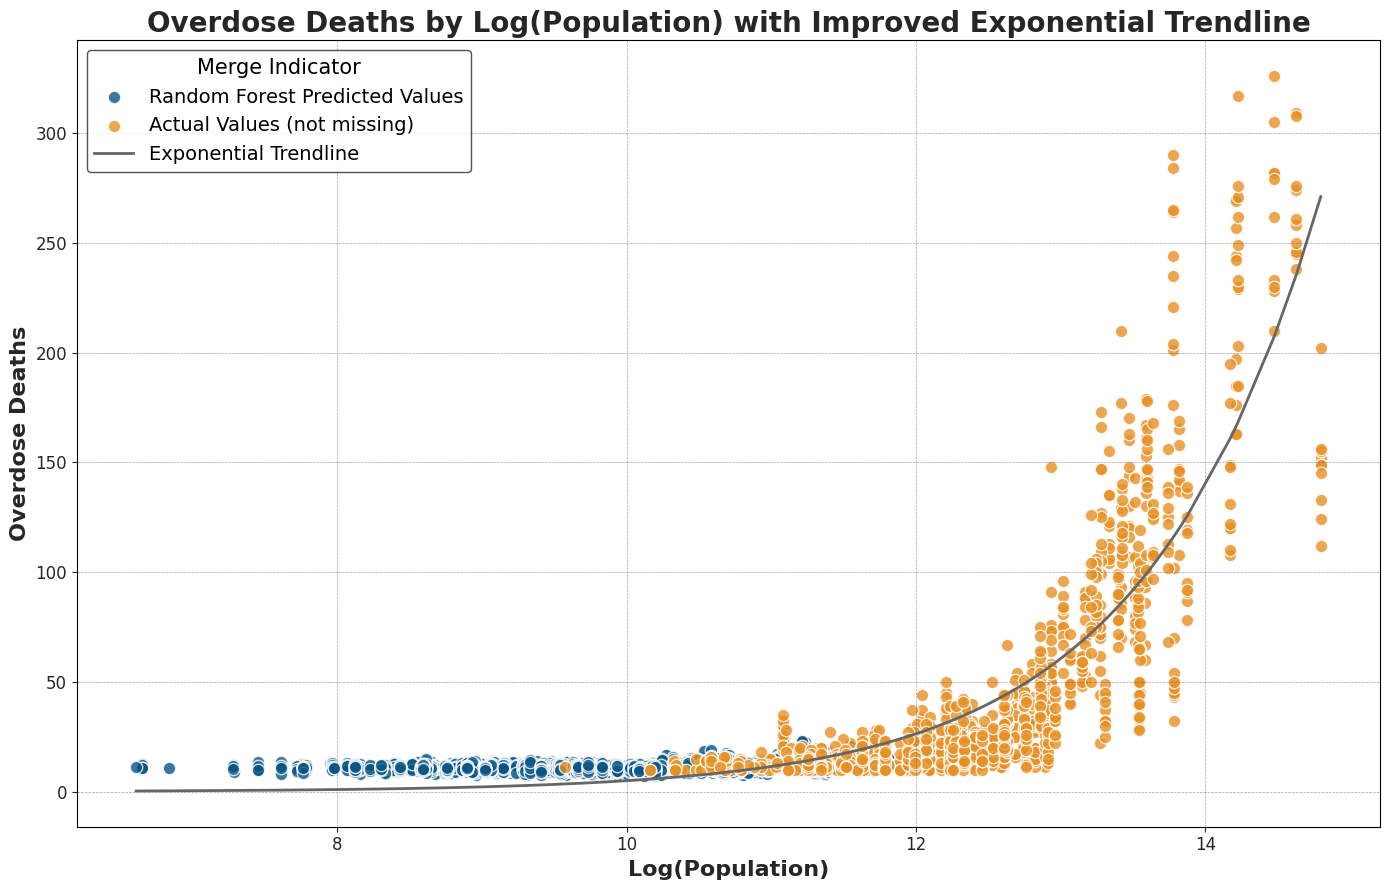

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# Define an exponential function for better fitting
def exponential_func(x, a, b):
    return a * np.exp(b * x)


# Extracting x and y data
x = np.array(final_dataset["pop_log_population"])
y = np.array(final_dataset["mort_overdose_deaths"])
labels = np.array(final_dataset["mort_merge_indicator"])

# Fit the exponential trendline to the data
params, _ = curve_fit(exponential_func, x, y, maxfev=10000)
a, b = params

# Calculate the trendline
x_sorted = np.sort(x)
y_trendline = exponential_func(x_sorted, a, b)

# Standardize label values for color mapping
final_dataset["mort_merge_indicator"] = final_dataset["mort_merge_indicator"].replace(
    {"Actual Values(not missing)": "Actual Values (not missing)"}
)
labels = np.array(final_dataset["mort_merge_indicator"])

# Assign colors based on labels
color_map = {
    "Random Forest Predicted Values": "#085587",  # Prussian Blue
    "Actual Values (not missing)": "#E89023",  # Persimmon
}
colors = [color_map.get(label, "#FFFFFF") for label in labels]

# Plot setup
plt.figure(figsize=(14, 9))
for label, color in color_map.items():
    plt.scatter(
        x[labels == label],
        y[labels == label],
        c=color,
        label=label,
        alpha=0.8,
        edgecolors="white",
        s=80,
    )
plt.plot(
    x_sorted, y_trendline, color="#666666", label="Exponential Trendline", linewidth=2
)

# Styling for a professional look
plt.gca().set_facecolor("#FFFFFF")  # White background
plt.title(
    "Overdose Deaths by Log(Population) with Improved Exponential Trendline",
    fontsize=20,
    color="#262626",
    weight="bold",
)
plt.xlabel("Log(Population)", fontsize=16, color="#262626", weight="bold")
plt.ylabel("Overdose Deaths", fontsize=16, color="#262626", weight="bold")
plt.legend(
    title="Merge Indicator",
    fontsize=14,
    title_fontsize=15,
    edgecolor="#262626",
    loc="upper left",
)
plt.grid(color="#666666", linestyle="--", linewidth=0.5, alpha=0.6)
plt.tick_params(colors="#262626", labelsize=12)

# Display the updated chart
plt.tight_layout()
plt.show()

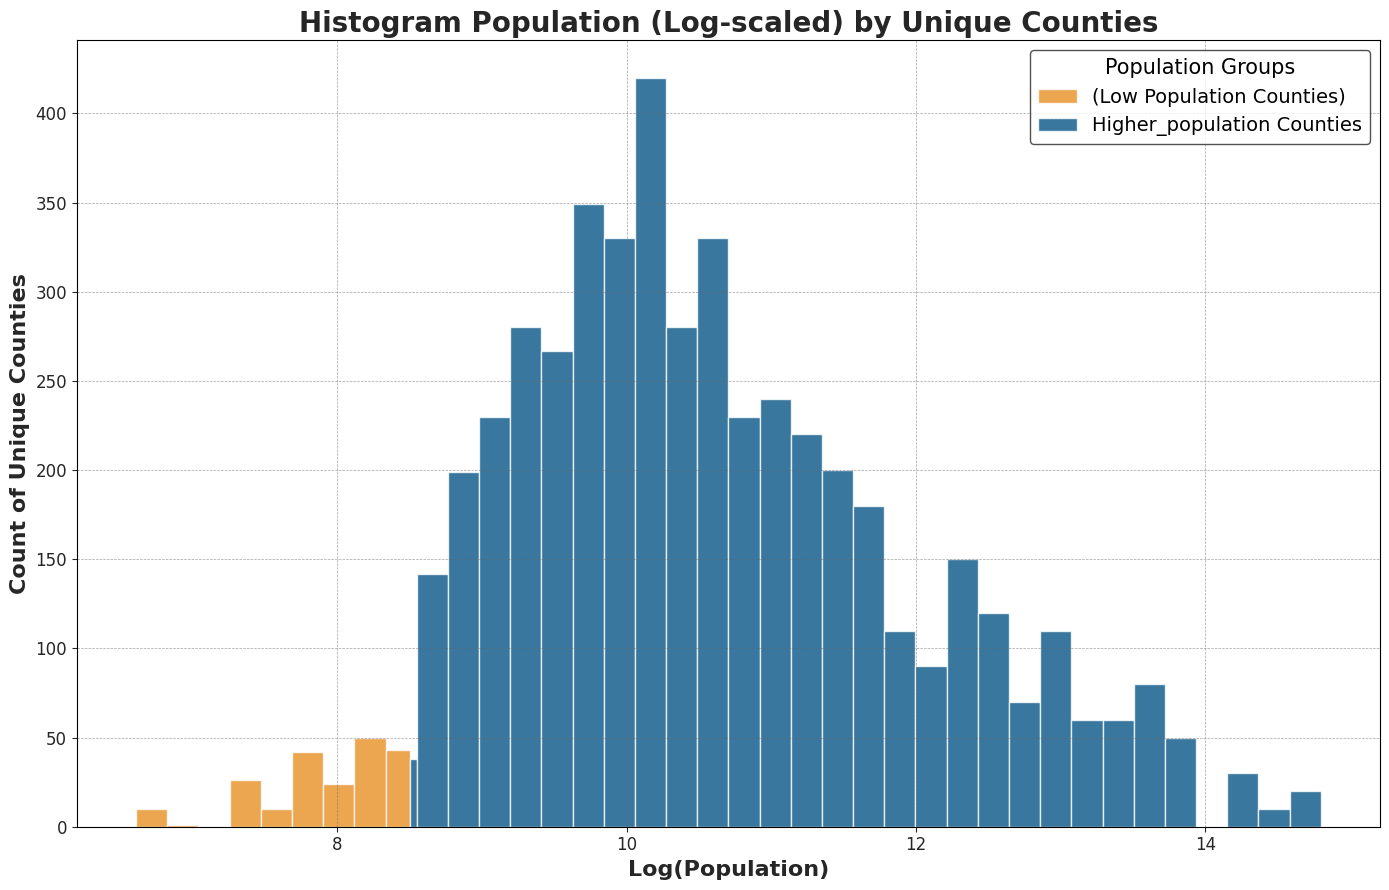

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Grouping populations into bins for the histogram
pop_data = np.array(final_dataset["pop_log_population"])
bin_edges = np.histogram_bin_edges(pop_data, bins="auto")

# Define the threshold for splitting the population
threshold = 8.5

# Separate the bins to avoid overlap
below_threshold_bins = bin_edges[bin_edges <= threshold]
above_threshold_bins = bin_edges[bin_edges > threshold]
below_threshold_bins = np.append(
    below_threshold_bins, threshold
)  # Add threshold as the upper limit
above_threshold_bins = np.insert(
    above_threshold_bins, 0, threshold
)  # Add threshold as the lower limit

# Separate below and above threshold
below_threshold = pop_data[pop_data <= threshold]
above_threshold = pop_data[pop_data > threshold]

# Plot the histogram
plt.figure(figsize=(14, 9))
plt.hist(
    below_threshold,
    bins=below_threshold_bins,
    color="#E89023",
    edgecolor="#FFFFFF",
    label="(Low Population Counties)",
    alpha=0.8,
)
plt.hist(
    above_threshold,
    bins=above_threshold_bins,
    color="#085587",
    edgecolor="#FFFFFF",
    label="Higher_population Counties",
    alpha=0.8,
)

# Styling for a professional look
plt.gca().set_facecolor("#FFFFFF")  # White background
plt.title(
    "Histogram Population (Log-scaled) by Unique Counties",
    fontsize=20,
    color="#262626",
    weight="bold",
)
plt.xlabel("Log(Population)", fontsize=16, color="#262626", weight="bold")
plt.ylabel("Count of Unique Counties", fontsize=16, color="#262626", weight="bold")
plt.legend(
    title="Population Groups",
    fontsize=14,
    title_fontsize=15,
    edgecolor="#262626",
    loc="upper right",
)
plt.grid(color="#666666", linestyle="--", linewidth=0.5, alpha=0.6)
plt.tick_params(colors="#262626", labelsize=12)

# Display the updated histogram
plt.tight_layout()
plt.show()

In [ ]:
final_dataset = final_dataset[final_dataset["pop_log_population"] >= 8.5]
final_dataset["grams_morphine_per_cap"] = final_dataset[
    "opioid_morphine_equivalent_g"
].astype("float") / final_dataset["pop_Population"].astype("int")

final_dataset["overdose_deaths_per_cap"] = final_dataset["mort_overdose_deaths"].astype(
    "int"
) / final_dataset["pop_Population"].astype("int")

C:\Users\chris\AppData\Local\Temp\ipykernel_16992\4114245981.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  florida_data['pop_Year'] = pd.to_numeric(florida_data['pop_Year'], errors='coerce')


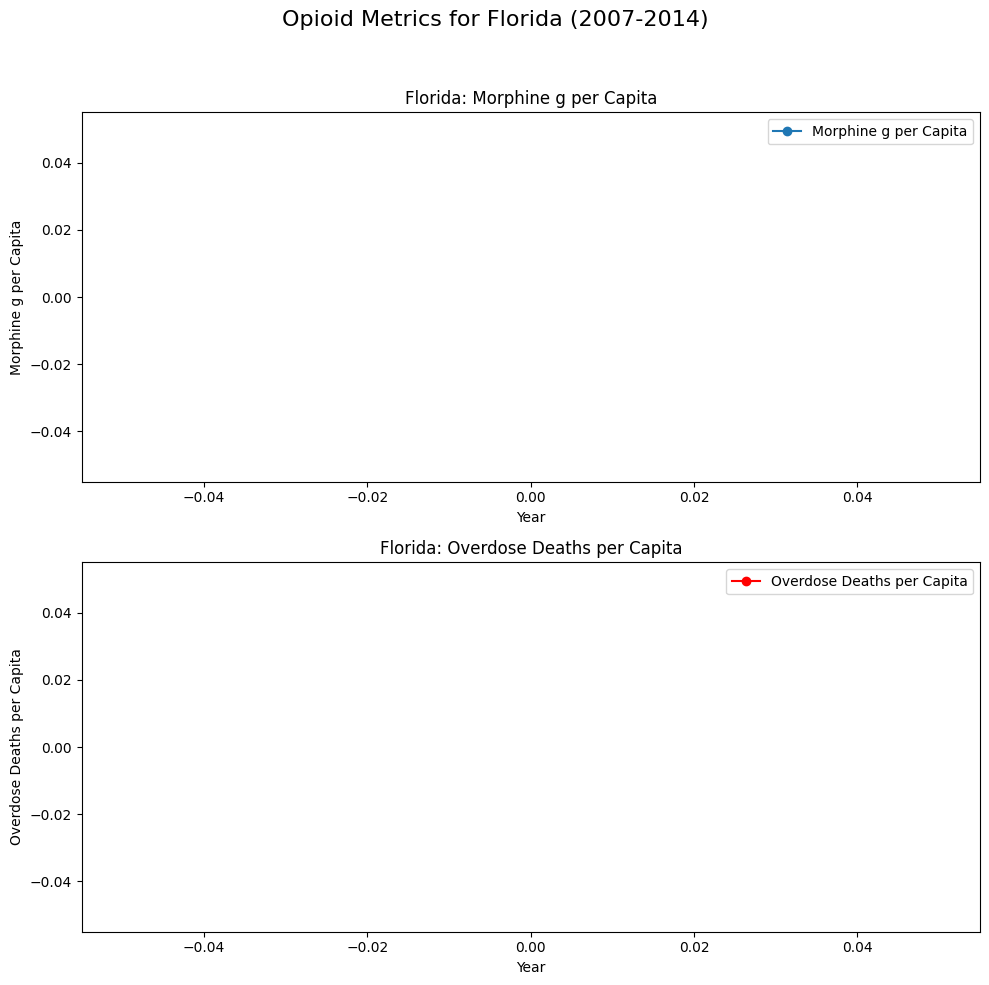

In [ ]:
def create_charts_florida_debug(final_dataset):
    # Filter for Florida only
    florida_data = final_dataset[final_dataset["State"] == "FL"]
    print("Filtered data for Florida:\n", florida_data.head())  # Debugging step

    # Convert 'pop_Year' to numeric (integer), handling potential errors
    florida_data["pop_Year"] = pd.to_numeric(florida_data["pop_Year"], errors="coerce")
    florida_data = florida_data.dropna(subset=["pop_Year"])
    print(
        "After converting 'pop_Year' to numeric:\n", florida_data[["pop_Year"]].head()
    )  # Debugging step

    # Ensure the years are in the range [2007, 2014]
    florida_data = florida_data[
        (florida_data["pop_Year"] >= 2007) & (florida_data["pop_Year"] <= 2014)
    ]
    print(
        "After filtering years between 2007 and 2014:\n", florida_data.head()
    )  # Debugging step

    # Calculate per capita metrics
    florida_data["morphine_per_capita"] = florida_data.groupby("pop_Year")[
        "opioid_morphine_equivalent_g"
    ].transform("sum") / florida_data.groupby("pop_Year")["pop_Population"].transform(
        "sum"
    )
    florida_data["deaths_per_capita"] = florida_data.groupby("pop_Year")[
        "mort_overdose_deaths"
    ].transform("sum") / florida_data.groupby("pop_Year")["pop_Population"].transform(
        "sum"
    )
    print(
        "Calculated per capita metrics:\n",
        florida_data[
            ["pop_Year", "morphine_per_capita", "deaths_per_capita"]
        ].drop_duplicates(),
    )  # Debugging step

    # Remove duplicates for year-level aggregation
    aggregated_data = florida_data.drop_duplicates(subset=["pop_Year"])
    print("Aggregated data for plotting:\n", aggregated_data)  # Debugging step

    # Create subplots for the two charts
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle("Opioid Metrics for Florida (2007-2014)", fontsize=16)

    # Chart 1: Morphine per capita
    axes[0].plot(
        aggregated_data["pop_Year"],
        aggregated_data["morphine_per_capita"],
        marker="o",
        label="Morphine g per Capita",
    )
    axes[0].set_title("Florida: Morphine g per Capita")
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("Morphine g per Capita")
    axes[0].legend()

    # Chart 2: Overdose deaths per capita
    axes[1].plot(
        aggregated_data["pop_Year"],
        aggregated_data["deaths_per_capita"],
        marker="o",
        color="red",
        label="Overdose Deaths per Capita",
    )
    axes[1].set_title("Florida: Overdose Deaths per Capita")
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Overdose Deaths per Capita")
    axes[1].legend()

    # Adjust layout and show plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Call the debug function
create_charts_florida_debug(final_dataset=final_dataset)